# Diffusivity

This notebook analyze the diffusivity based on the trajectory data.

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import trackpy as tp
from skimage import io
from corrLib import readdata, xy_bin
from xiaolei.chain.tracking import gauss1
from scipy.optimize import curve_fit
from myImageLib import bestcolor
from utils import *
import dufte
plt.style.use('default')

## Load trajectory

In [7]:
folder = '/home/zhengyang/data/DE/07212021/2021-07-21_16h41m52s'
data = pd.read_csv(os.path.join(folder, 'crop_HoughCircles', 'xyz-traj.csv'))

In [11]:
t = data.assign(particle=0)

(-0.5, 424.5, 387.5, -0.5)

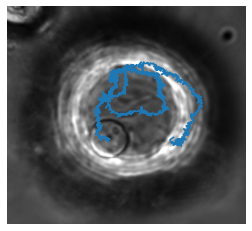

In [12]:
mpp = 0.16
l = readdata(folder, 'tif')
img = io.imread(l.Dir.iloc[0])
plt.figure()
plt.imshow(img, cmap='gray')
plt.plot(data.x/mpp, data.y/mpp)
plt.axis('off')

## 2D vs. 3D

In [168]:
msd = tp.msd(t, mpp=1, fps=30, max_lagtime=1500)
msd3 = tp.msd(t.dropna(), mpp=1, fps=30, max_lagtime=1500, pos_columns=['z', 'x', 'y'])

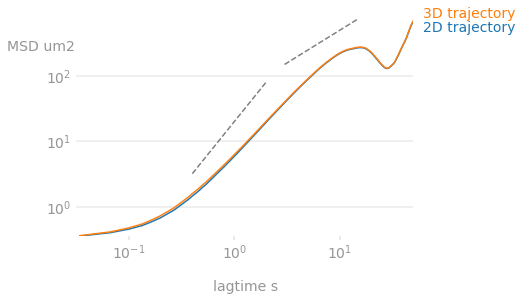

In [174]:
plt.plot(msd.lagt, msd.msd, label='2D trajectory')
plt.plot(msd3.lagt, msd3.msd, label='3D trajectory')

# plt.plot([1e-1, 60], [d**2, d**2], ls='--', color='gray', label='Diameter 5200')
plt.loglog()

x = np.array([.4, 2])
y = 20* x ** 2
plt.plot(x, y, color='gray', ls='--')

x = np.array([3, 15])
y =  50* x ** 1
plt.plot(x, y, color='gray', ls='--')
dufte.ylabel('MSD um2')
plt.xlabel('lagtime s')
dufte.legend()

**Comments:**
- Cristian's data shows ballistic regime at ~0.02 s, diffusive regime at ~1 s and subdiffusive (plateau) regime at ~10 s. To produce data that is comparable to his, longer video with higher frame rate is necessary (80 fps for 1000 s)
- In the video(0716/3), the outer droplet moves significantly. As a result, the motion of inner droplet is affected. For more accurate analysis, I need to track the outer droplet and subtract its motion from the inner's.
- 3D trajectory is obtained (0720/16h42m). 2D and 3D MSD's are compared. They are very similar in long time limit, indicating that Z-motion is weaker than XY-motion. 3D MSD is higher in short time limit, likely due to manual tracking error.

## MSD of different experiments

In [60]:
d = {} # traj data directories
d['50/11[23]'] = '/home/zhengyang/data/DE/07212021/2021-07-21_16h41m52s/crop_HoughCircles/xyz-traj.csv'
d['72/8[32]'] = '/home/zhengyang/data/DE/07202021/1st-drop-tracking/2021-07-20_16h42m46s/crop_HoughCircles/xyz-traj.csv'
d['100/34[20]'] = '/home/zhengyang/data/DE/07132021/2021-07-13_17h17m24s/crop_HoughCircles/xyz-traj.csv'
plt.style.use(dufte.style)

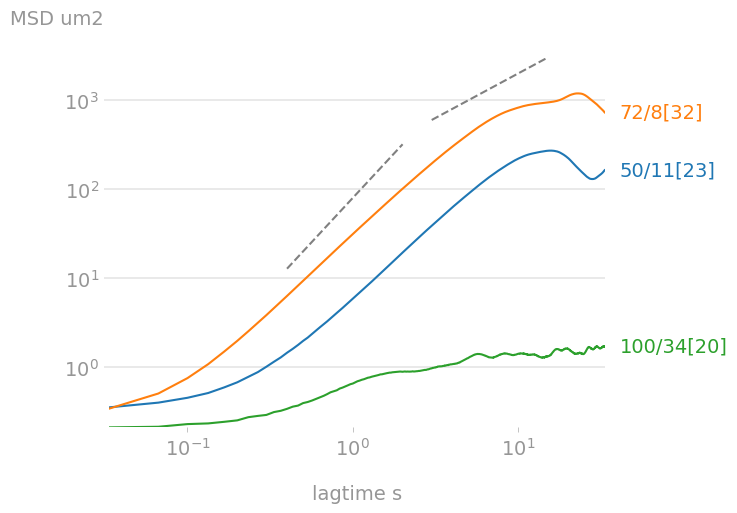

In [61]:
fig, ax = plt.subplots()

for kw in d:
    traj = pd.read_csv(d[kw]).assign(particle=0).rename(columns={'filename': 'frame'})
    msd = tp.msd(traj, mpp=1, fps=30, max_lagtime=1000)
    ax.plot(msd.lagt, msd.msd, label=kw)
ax.loglog()
dufte.legend()
dufte.ylabel('MSD um2')
ax.set_xlabel('lagtime s')

x = np.array([.4, 2])
y = 80* x ** 2
ax.plot(x, y, color='gray', ls='--')

x = np.array([3, 15])
y =  200* x ** 1
ax.plot(x, y, color='gray', ls='--')

## Displacement distribution (PDF)

### Minimal code

In [26]:
folder = '/home/zhengyang/data/DE/07202021/1st-drop-tracking/2021-07-20_16h42m46s/crop_HoughCircles'
traj = pd.read_csv(os.path.join(folder, 'xyz-traj.csv'))

<AxesSubplot:>

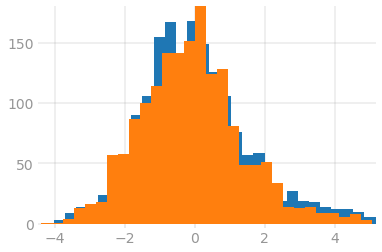

In [27]:
dx = traj.x.diff(10)
dy = traj.y.diff(10)
fig, ax = plt.subplots()
dx.hist(bins=30, ax=ax)
dy.hist(bins=30, ax=ax)

### Take 07202021 data for example

- This dataset contains 15 videos of the same DE system
- All the videos are taken at 30 fps for ~1 min
- Imaging begins at 16:24 and ends at 16:51

#### Compare different videos at same dt
- dt = 0.03, 0.33, 1, 3 are shown (1, 10, 30, 90 in frames)

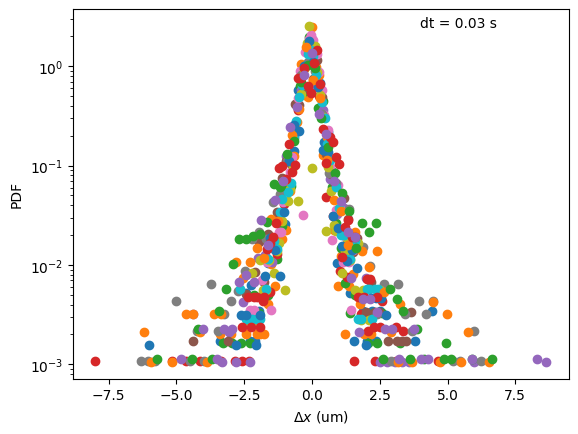

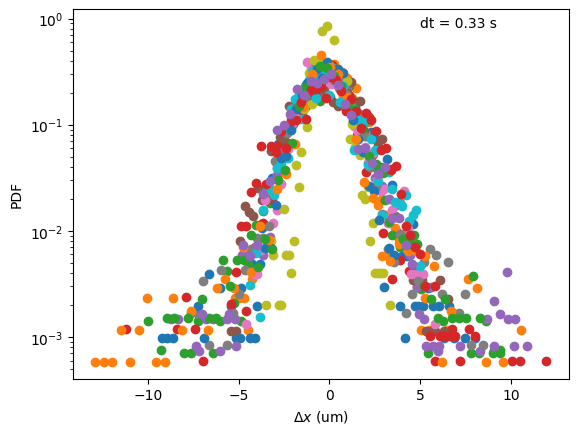

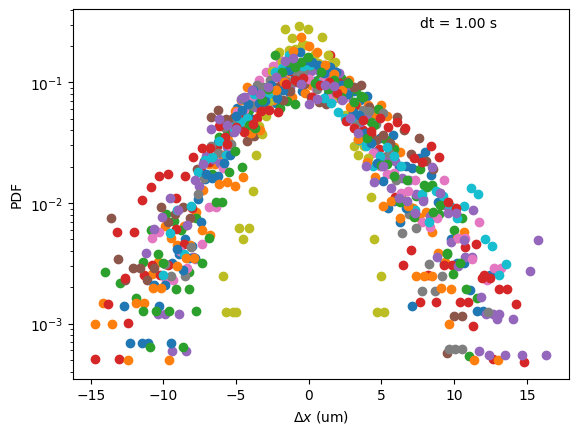

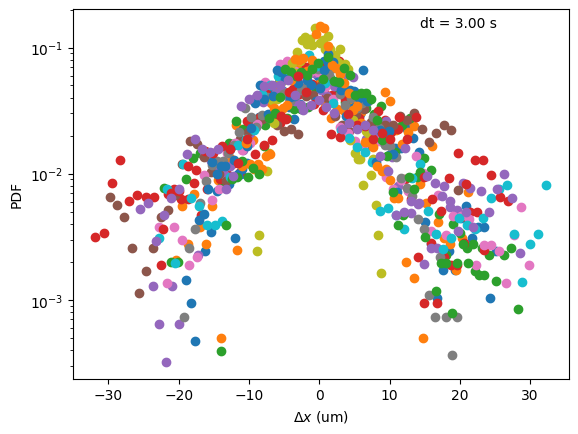

In [53]:
log = pd.read_csv('../../Data/main_log.csv', header=[0, 1])
slog = log.loc[log[('params', 'Date')]==7202021]
folder = '/home/zhengyang/data/DE'

for dt in [1, 10, 30, 90]:
    fig, ax = plt.subplots()
    
    for num, i in slog.iterrows():
#         date = '{:08d}'.format(i[('params', 'Date')])
#         subfolder = i[('params', 'Subfolder')]
#         traj = pd.read_csv(os.path.join(folder, date, subfolder, 'crop_HoughCircles', 'xyz-traj.csv'))
        traj = load_xyz_traj(i, folder)
        dx = traj.x.diff(dt)
        dy = traj.y.diff(dt)
        hist, bin_edges = np.histogram(pd.concat([dx, dy]).dropna(), bins=50, density=True)
        ax.plot(bin_edges[:-1], hist, ls='', marker='o')
    ax.set_yscale('log')
    ax.set_ylabel('PDF')
    ax.set_xlabel('$\Delta x$ (um)')
    ax.text(0.7, 0.95, 'dt = {:.2f} s'.format(dt/i[('params', 'FPS')]), transform=ax.transAxes)

**Comments**

- PDFs are characterized by a Gaussian core and non-Gaussian tails
- PDFs get wider with increasing dt
- PDFs are similar for same dt, it's reasonable to average 

### Compare PDFs for different parameters (size ratio, inner size, ...)

- fix dt at 0.33 s

##### 1. Based on the size ratio between outer and inner droplets

In [68]:
r = log[('analysis', 'OD')] / log[('analysis', 'ID')]
r.max(), r.min()

(8.535714285714286, 1.847422680412371)

Groups: (0, 3), (3, 5), (5, 7), (7, 9)

Text(0.5, 1.0, 'ratio')

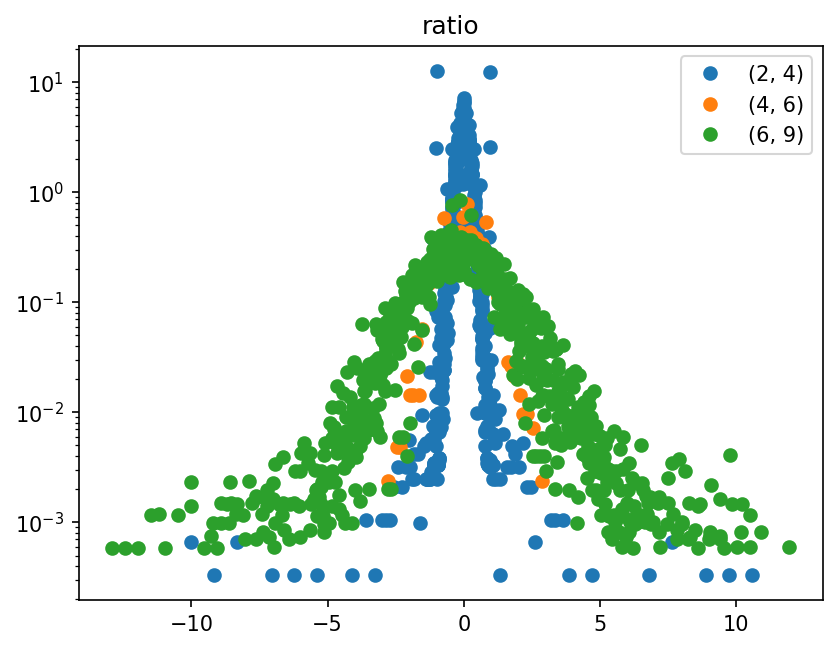

In [92]:
lims = [(2, 4), (4, 6), (6, 9)]
dt = 10
folder = '/home/zhengyang/data/DE'
fig, ax = plt.subplots(dpi=150)
h = {}
for c, lim in enumerate(lims):
    slog = log.loc[(r>lim[0])&(r<=lim[1])&(log[('analysis', '3D-trajectory')]==1)]
    for num, i in slog.iterrows():
        date = '{:08d}'.format(i[('params', 'Date')])
        subfolder = i[('params', 'Subfolder')]
        traj = pd.read_csv(os.path.join(folder, date, subfolder, 'crop_HoughCircles', 'xyz-traj.csv'))
        dx = traj.x.diff(dt)
        dy = traj.y.diff(dt)
        hist, bin_edges = np.histogram(pd.concat([dx, dy]).dropna(), bins=50, density=True)
        h[c], = ax.plot(bin_edges[:-1], hist, ls='', marker='o', label=subfolder, color=bestcolor(c))
        ax.set_yscale('log')
ax.legend([h[0], h[1], h[2]], lims)
ax.set_title('ratio')

##### 2. Inner droplet size

Text(0.5, 1.0, 'inner drop diameter')

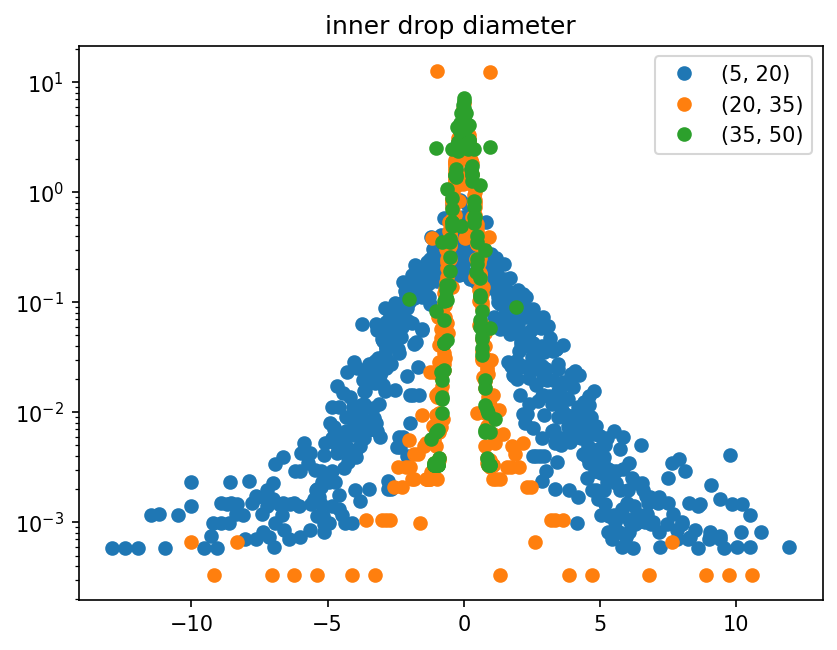

In [95]:
lims = [(5, 20), (20, 35), (35, 50)]
dt = 10
folder = '/home/zhengyang/data/DE'
fig, ax = plt.subplots(dpi=150)
h = {}
for c, lim in enumerate(lims):
    slog = log.loc[(log[('analysis', 'ID')]>lim[0])&(log[('analysis', 'ID')]<=lim[1])&(log[('analysis', '3D-trajectory')]==1)]
    for num, i in slog.iterrows():
        date = '{:08d}'.format(i[('params', 'Date')])
        subfolder = i[('params', 'Subfolder')]
        traj = pd.read_csv(os.path.join(folder, date, subfolder, 'crop_HoughCircles', 'xyz-traj.csv'))
        dx = traj.x.diff(dt)
        dy = traj.y.diff(dt)
        hist, bin_edges = np.histogram(pd.concat([dx, dy]).dropna(), bins=50, density=True)
        h[c], = ax.plot(bin_edges[:-1], hist, ls='', marker='o', label=subfolder, color=bestcolor(c))
        ax.set_yscale('log')
ax.legend([h[0], h[1], h[2]], lims)
ax.set_title('inner drop diameter')

## Z Position distribution

The inner droplet is in a potential well due to the buoyant force. For a Brownian particle undertaking random walk, the position distribution in z should follow a Boltzmann distribution, where $P(z) = P_0e^{-U(z)/kT}$. Here, I assume the motion of inner droplets is always constrained to the outer surface and calculate $P(z)$.

### Group with ID

In [2]:
log = pd.read_csv('../../Data/main_log.csv', header=[0, 1])
slog = log.loc[(log['analysis', '3D-trajectory']==1)] # retrieve data with xyz traj
folder = '/home/zhengyang/data/DE'

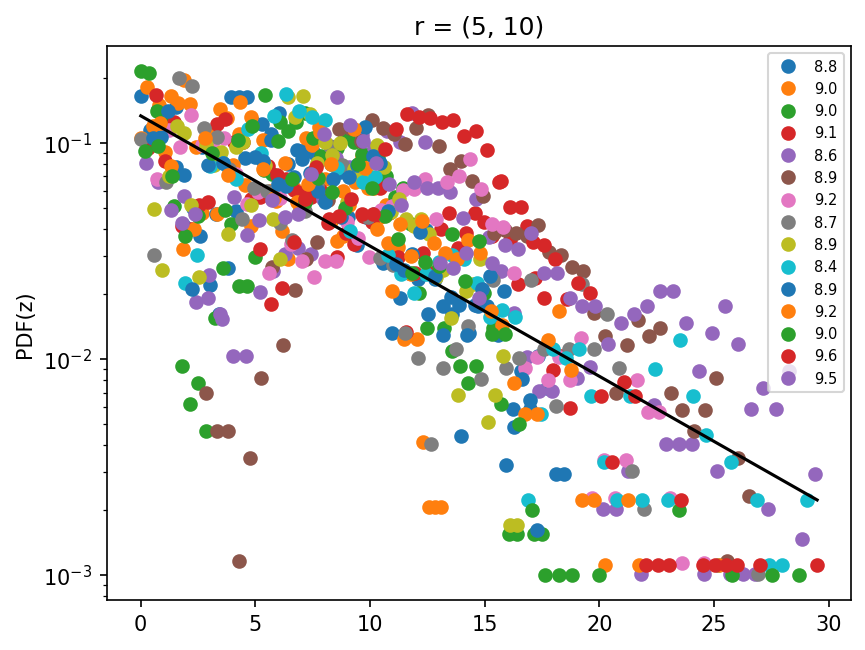

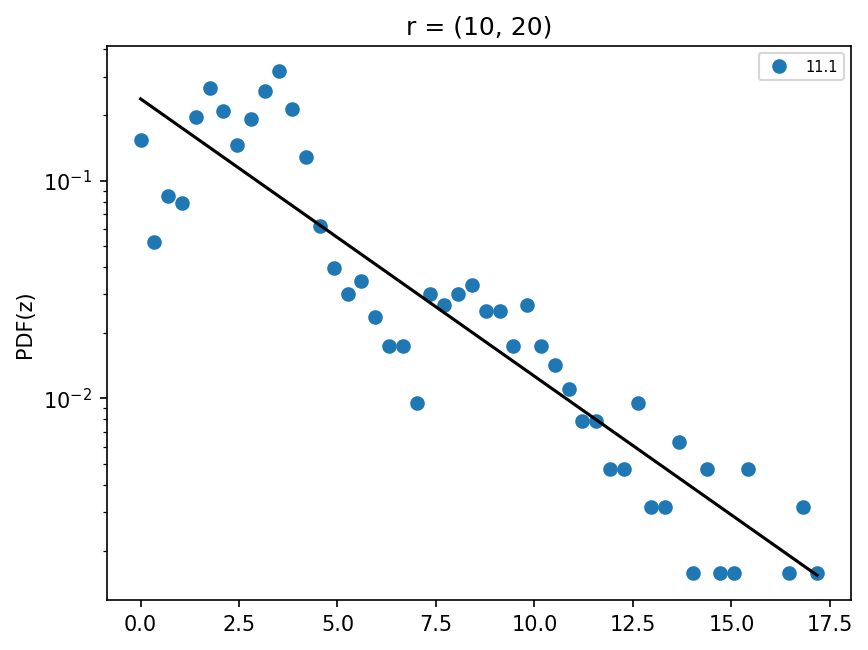

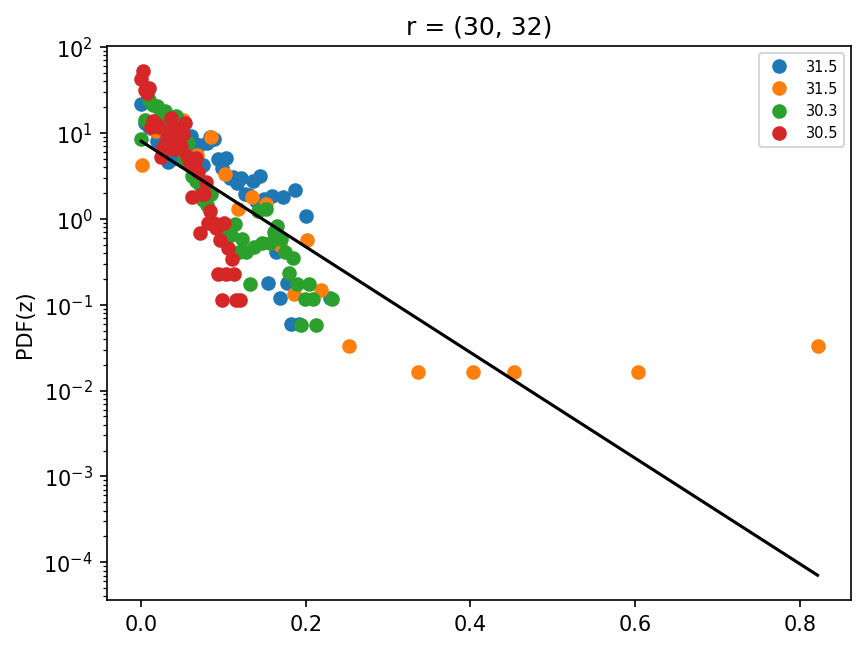

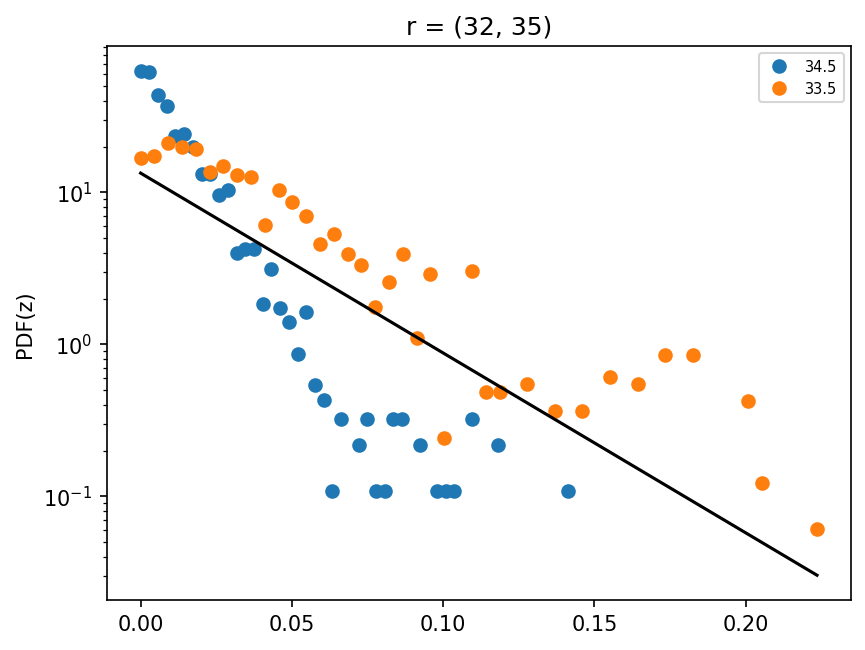

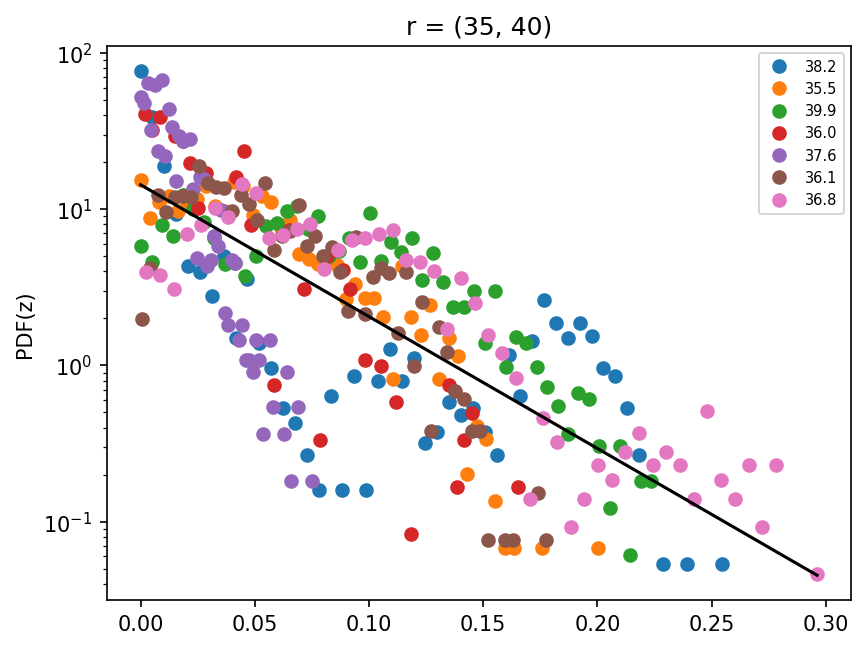

In [39]:
# ID groups (5, 20), (20, 35), (35, 50)
lims = [(5, 10), (10, 20), (30, 32), (32, 35), (35, 40)]
count = 0
main_df = pd.DataFrame()
for lim in lims:
    fig, ax = plt.subplots(dpi=150)
    slog = log.loc[(log['analysis', '3D-trajectory']==1) & (log['analysis', 'ID']>=lim[0]) & (log['analysis', 'ID']<lim[1])]
    group_df = pd.DataFrame()
    for num, i in slog.iterrows():
        traj = center_traj(i, folder)
        hist, bin_edges = np.histogram(traj.z.dropna(), bins=50, density=True)
        ax.plot(bin_edges[:-1], hist, ls='', marker='o', label=i['analysis', 'ID'])
        temp_df = pd.DataFrame({'z': bin_edges[:-1], 
                                'hist': hist, 
                                'ID': i['analysis', 'ID']*np.ones(len(hist)),
                                'OD': i['analysis', 'OD']*np.ones(len(hist)),
                                'group': count*np.ones(len(hist)), 
                                'lim_min': lim[0],
                                'lim_max': lim[1],
                                'data_id': num})
        group_df = pd.concat((group_df, temp_df))
        
    # fit group_df with y = ax + b
    fit_df = group_df.loc[group_df['hist']>0].sort_values(by='z')
    p = np.polyfit(fit_df.z, np.log(fit_df['hist']), 1)
    x = np.array([fit_df.z.min(), fit_df.z.max()])
    y = p[0] * x + p[1]
    ax.plot(x, np.exp(y), color='black')    
    
    main_df = pd.concat((main_df, group_df))    
    ax.set_yscale('log')
    ax.legend(fontsize=7)
    ax.set_title('r = {}'.format(lim))
    ax.set_ylabel('PDF(z)')  
    
    count += 1

- Plot PDF in a different style

/home/zhengyang/Documents/GitHub/Python/mylib/corrLib.py:678: RuntimeWarning: invalid value encountered in true_divide
  y = (np.histogram(xo, x, weights=yo)[0] /
/home/zhengyang/Documents/GitHub/Python/mylib/corrLib.py:678: RuntimeWarning: invalid value encountered in true_divide
  y = (np.histogram(xo, x, weights=yo)[0] /
/home/zhengyang/Documents/GitHub/Python/mylib/corrLib.py:678: RuntimeWarning: invalid value encountered in true_divide
  y = (np.histogram(xo, x, weights=yo)[0] /
/home/zhengyang/Documents/GitHub/Python/mylib/corrLib.py:678: RuntimeWarning: invalid value encountered in true_divide
  y = (np.histogram(xo, x, weights=yo)[0] /


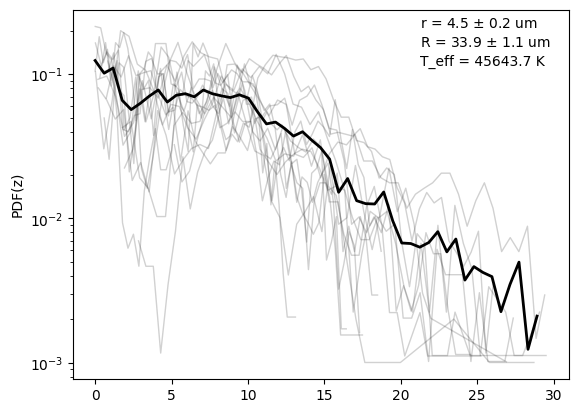

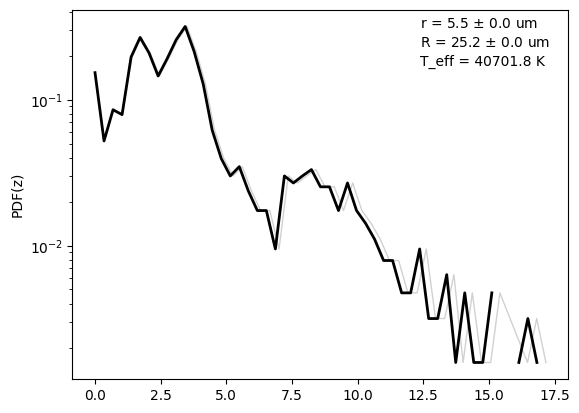

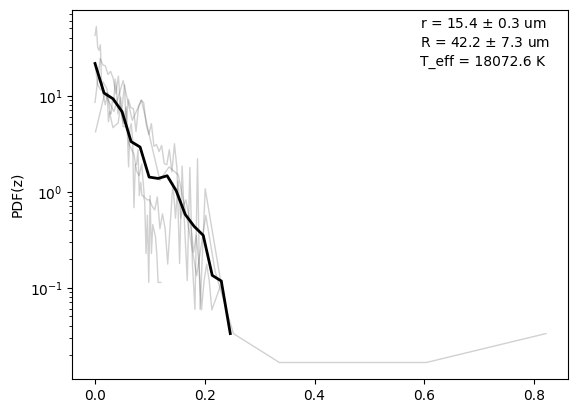

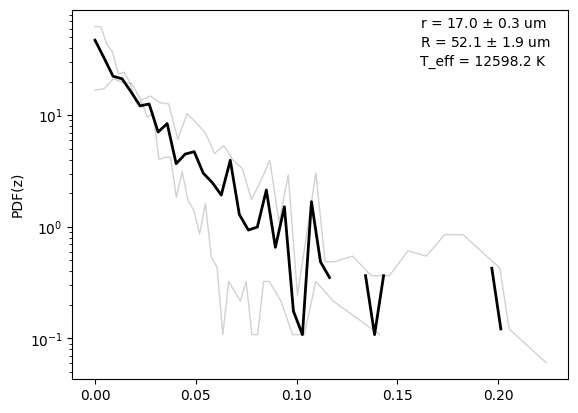

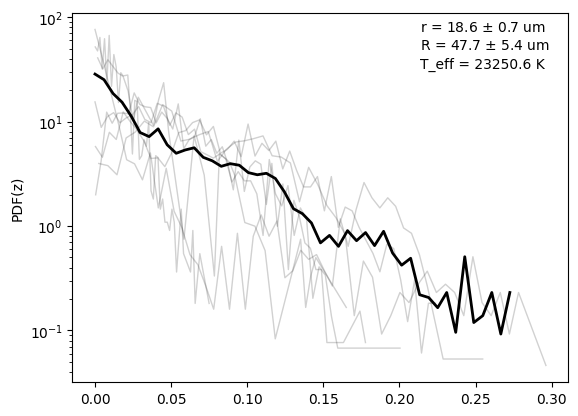

In [46]:
for num, g in enumerate(main_df['group'].drop_duplicates()):
    fig, ax = plt.subplots()
    group_df = main_df.loc[(main_df['hist']>0)&(main_df['group']==g)].sort_values(by='z')
    for data_id in group_df['data_id'].drop_duplicates():
        df = group_df.loc[group_df['data_id']==data_id]
        ax.plot(df['z'], df['hist'], color=(.1,.1,.1,0.2), lw=1)
    x, y = xy_bin(group_df['z'], group_df['hist'], mode='lin', n=50)
    ax.plot(x, y, color='black', lw=2)
    ax.set_yscale('log')
    ax.set_ylabel('PDF(z)')
    r = group_df['ID'].mean() / 2
    err = group_df['ID'].std() / 2
    R = group_df['OD'].mean() / 2
    Rerr = group_df['OD'].std() / 2
    p = np.polyfit(group_df['z'], np.log(group_df['hist']), 1)
    T = effective_temperature(p[0], r)
    ax.text(0.7, 0.95, 'r = {0:.1f} $\pm$ {1:.1f} um'.format(r, err), transform=ax.transAxes)
    ax.text(0.7, 0.9, 'R = {0:.1f} $\pm$ {1:.1f} um'.format(R, Rerr), transform=ax.transAxes)
    ax.text(0.7, 0.85, 'T_eff = {:.1f} K'.format(T), transform=ax.transAxes)

In [41]:
def effective_temperature(slope, inner_radius):
    '''Compute effective temperature based on z PDF
    
    Args:
    slope -- slope of linear fitting of PDF(z)
    inner_radius -- inner droplet radius (um)
    
    Returns:
    T -- effective temperature
    '''
    
    a = slope * 1e6
    r = inner_radius * 1e-6
    k = 1.38e-23
    T = (4/3) * np.pi * r**3 * (770-1000) / k / a
    
    return T